下面将使用预训练好的 VGG16 来训练猫和狗的分类网络。

In [1]:
import tensorflow as tf
from keras import models
from keras import layers
from keras.applications import VGG16

In [2]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

2023-09-30 23:59:48.685472: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-09-30 23:59:48.685532: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-09-30 23:59:48.685547: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-09-30 23:59:48.685616: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-30 23:59:48.685641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


在编译模型之前，非常重要的一步是 **冻结卷积网络的参数**。因为我们是使用预训练好的卷积网络，然后再在其最后添加用于分类的全连接层。如果不冻结，那么在训练的时候，很有可能分类网络的变动会通过反向传播破坏卷积网络的预训练参数。所以正确的做法应该先冻结卷积网络，训练，然后再解冻，再训练。

In [3]:
conv_base.trainable = False
print(len(model.trainable_weights))

4


In [4]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/train'
validation_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/validation'
test_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# !!! The validation data shouldn't be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), # resize image to 150 x 150
    batch_size=20,
    class_mode='binary'
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150), # resize image to 150 x 150
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/150


2023-09-30 23:59:49.760160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 13s 105ms/step - loss: 0.5956 - accuracy: 0.6795 - val_loss: 0.4412 - val_accuracy: 0.8180
Epoch 2/150
100/100 [==============================] - 11s 106ms/step - loss: 0.4818 - accuracy: 0.7740 - val_loss: 0.3687 - val_accuracy: 0.8500
Epoch 3/150
100/100 [==============================] - 10s 104ms/step - loss: 0.4270 - accuracy: 0.8115 - val_loss: 0.3310 - val_accuracy: 0.8690
Epoch 4/150
100/100 [==============================] - 10s 104ms/step - loss: 0.4074 - accuracy: 0.8140 - val_loss: 0.3148 - val_accuracy: 0.8670
Epoch 5/150
100/100 [==============================] - 10s 102ms/step - loss: 0.3860 - accuracy: 0.8250 - val_loss: 0.2961 - val_accuracy: 0.8840
Epoch 6/150
100/100 [==============================] - 10s 101ms/step - loss: 0.3702 - accuracy: 0.8335 - val_loss: 0.2825 - val_accuracy: 0.8900
Epoch 7/150
100/100 [==============================] - 10s 102ms/step - loss: 0.3653 - accuracy: 0.8420 - val_loss: 0.2780 - val_accurac

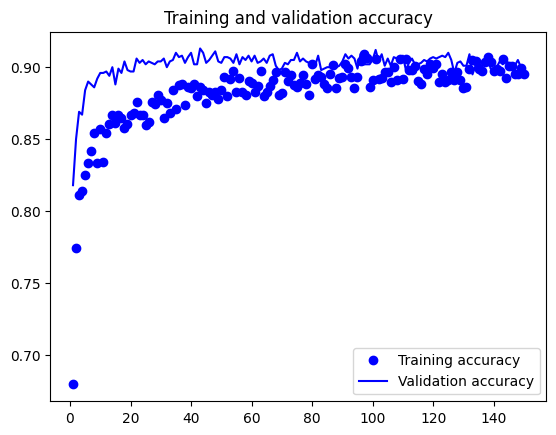

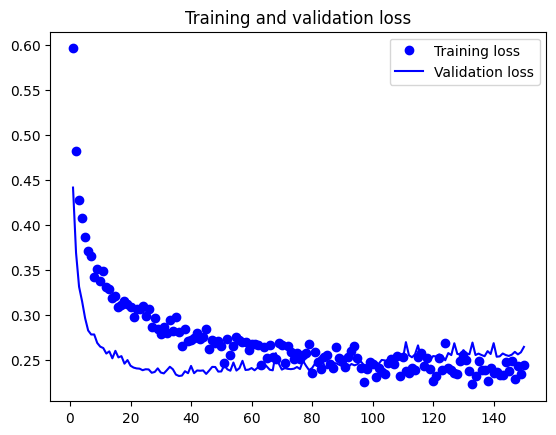

In [9]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()